# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post ECT.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel
from pingouin import ttest, normality, wilcoxon

from ect_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
%matplotlib inline

### Functions

In [3]:
def perm_test(df, feature='', nreps=10000, seed=256, plot_hist=True, run_ttest=True):
    '''permutation test from https://www.uvm.edu/\~statdhtx/StatPages/\
    ResamplingWithR/RandomMatchedSample/RandomMatchedSampleR.html
    '''
    
    means_pre = df[df['pre_post']=='pre'][feature].values
    means_post = df[df['pre_post']=='post'][feature].values
    
    diff_obt = np.nanmedian(means_post) - np.nanmedian(means_pre)
    difference = means_post-means_pre
    
    np.random.seed(seed)
    resamp_mean_diff = np.zeros(nreps)

    for i in range(0, nreps):
        signs = np.random.choice([1, -1], len(difference), replace=True)
        resamp = difference * signs
        resamp_mean_diff[i] = np.nanmedian(resamp)

    diff_obt = abs(diff_obt)
    highprob = len(resamp_mean_diff[resamp_mean_diff >= diff_obt])/nreps
    lowprob = len(resamp_mean_diff[resamp_mean_diff <= -diff_obt])/nreps
    prob2tailed = lowprob + highprob

    print("The probability from the sampling statistics is = ",prob2tailed,'\n')

    if plot_hist:
        plt.hist(resamp_mean_diff, bins=30);
        plt.title(feature)
        plt.xlabel('Median Difference')
        plt.axvline(x=diff_obt, c='r')
        plt.axvline(x=-diff_obt, c='r')

    # compare to student's t-test
    if run_ttest:
        print(ttest(means_pre, means_post, paired=True))

In [4]:
FRONTAL_ONLY = True

In [5]:
# load dataframe
exp_df = pd.read_csv('../saved_files/ect_files/ect_all_features.csv', index_col = 0)
# Exclude channels flagged as bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

In [6]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']
frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']


if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]

## Load SpecParam Fits

In [7]:
fits_pre = np.load('../saved_files/ect_files/fits_pre.npy')
fits_post = np.load('../saved_files/ect_files/fits_post.npy')
freq_axis = np.load('../saved_files/ect_files/freq_axis.npy')

**Correct for excluded fits**

In [8]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [9]:
psd_pre = np.load('../saved_files/ect_files/pre_ect_psd.npy')
psd_post = np.load('../saved_files/ect_files/post_ect_psd.npy')

**Correct for excluded PSD's**

In [10]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [11]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
60,3,pre,FP1,NaN,NaN,0.0,-12.241952,6.741872,1.781798,0.277813,-12.232633,10.453979,1.621720,0.837647,-11.801533,-12.158151,0.279629,0.031171,0.962810,False
61,3,pre,FPZ,NaN,NaN,0.0,-12.248181,6.729406,1.793935,0.280581,-12.230450,10.466818,1.587929,0.833965,-11.802431,-12.167226,0.268662,0.030654,0.963062,False
62,3,pre,FP2,NaN,NaN,0.0,-12.223583,6.771646,1.778848,0.225109,-12.243219,10.445258,1.652320,0.824597,-11.798229,-12.140973,0.266272,0.033978,0.955250,False
63,3,pre,AF3,NaN,NaN,0.0,-12.053576,6.728009,1.450483,0.264426,-12.108928,8.810163,1.350819,0.689642,-11.788350,-11.966515,0.325402,0.030016,0.952425,False
64,3,pre,AF4,NaN,NaN,0.0,-12.039139,6.677128,1.609865,0.246063,-12.063506,8.827587,1.372735,0.658331,-11.769375,-11.957553,0.284691,0.029641,0.950642,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,55,post,FC1,NaN,NaN,0.0,-10.323801,4.898780,2.994895,0.942876,-10.585264,9.773824,8.000000,0.606240,-11.301508,-9.877744,2.211869,0.114545,0.979217,False
2718,55,post,FCZ,NaN,NaN,0.0,-10.304091,5.081645,2.277209,0.934558,-10.481011,9.929518,8.000000,0.599762,-11.196323,-9.715885,2.247550,0.113617,0.977138,False
2719,55,post,FC2,NaN,NaN,0.0,-10.356412,4.800941,2.580863,0.974322,-10.595594,9.178513,7.999952,0.638257,-11.317068,-9.894878,2.227891,0.113717,0.979750,False
2720,55,post,FC4,NaN,NaN,0.0,-10.300355,4.612820,3.170510,0.872848,-10.699131,8.899215,2.455648,0.722238,-11.423784,-9.960597,2.097626,0.082460,0.986697,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

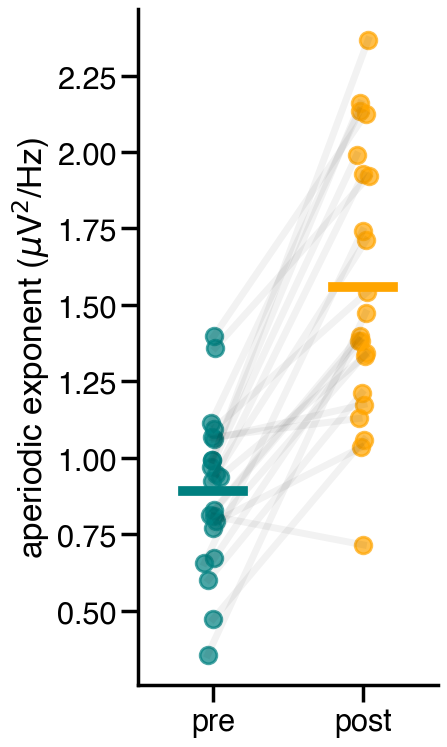

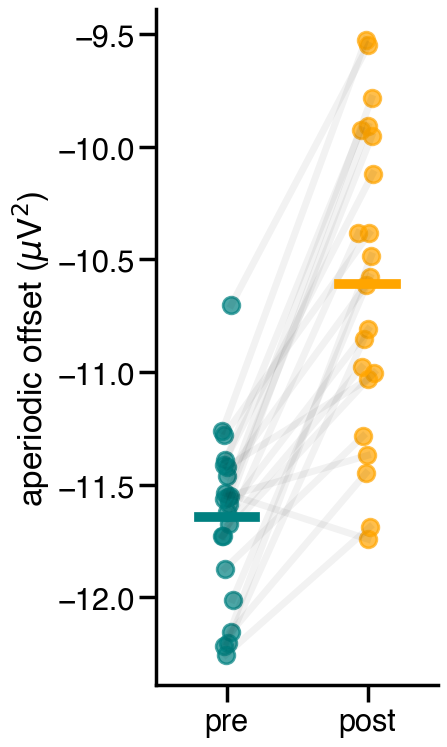

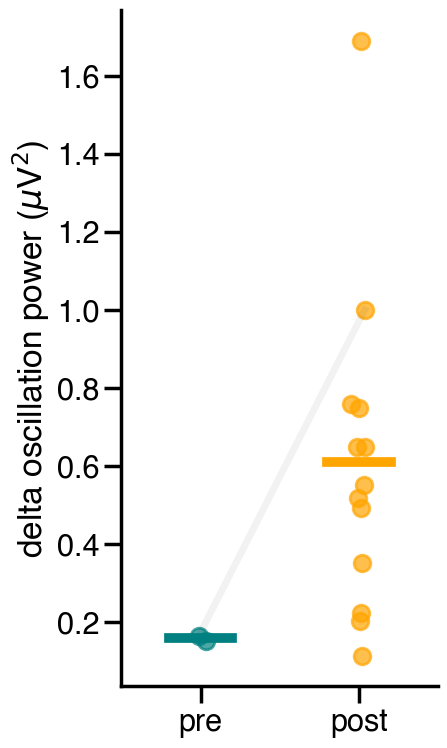

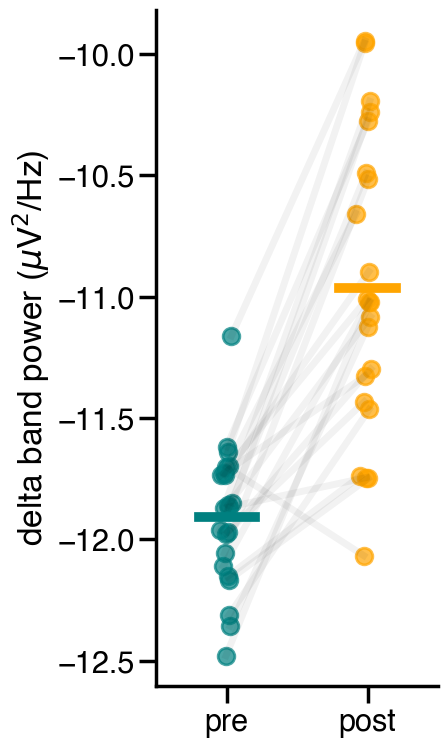

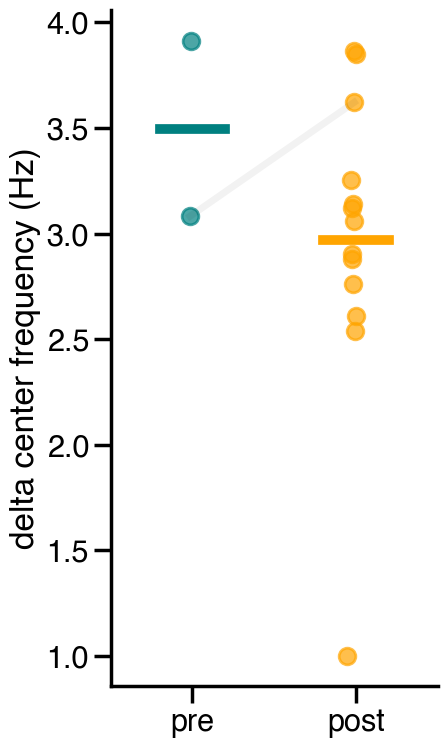

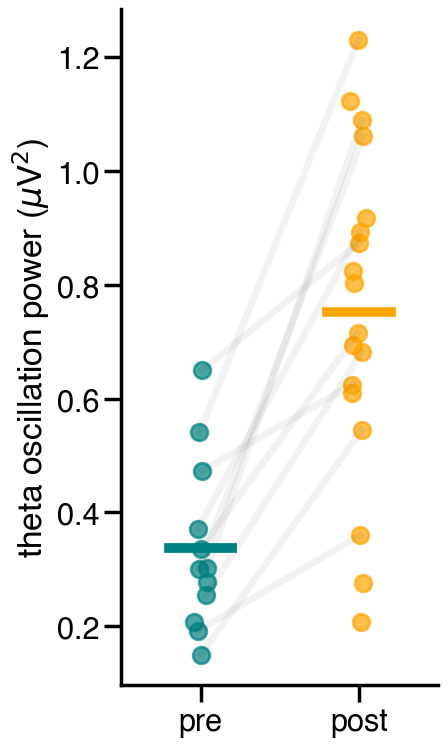

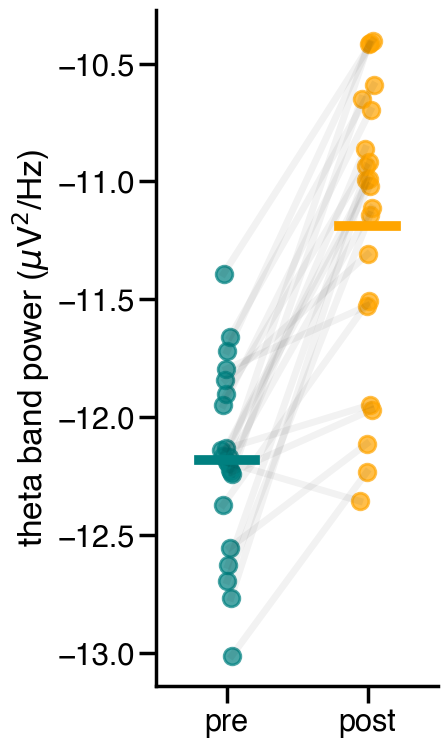

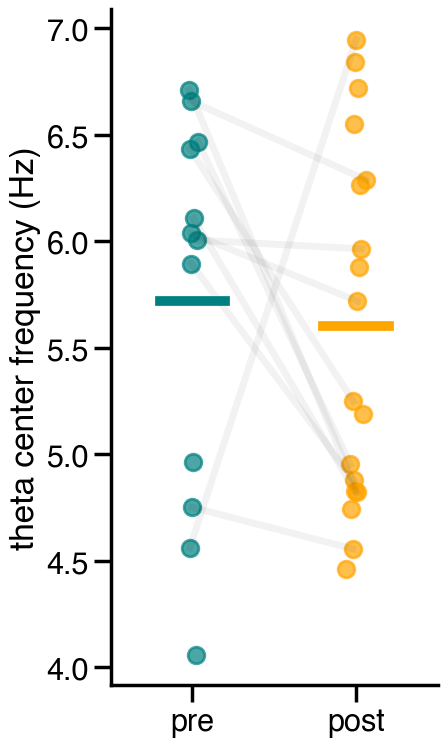

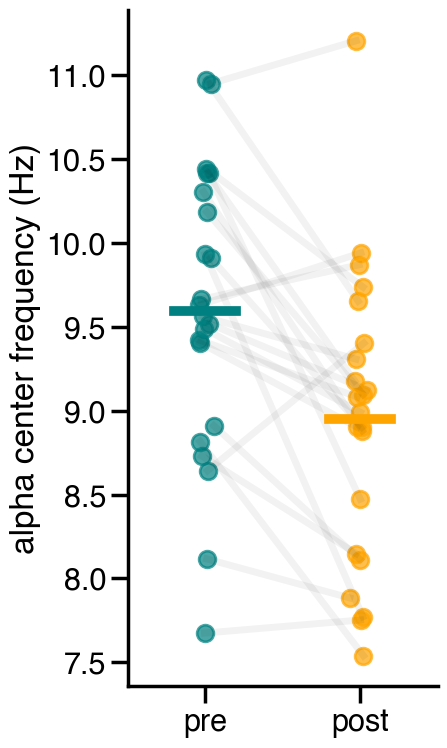

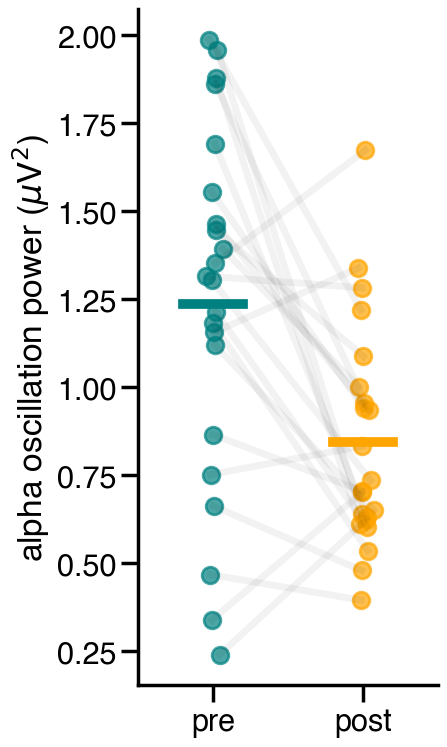

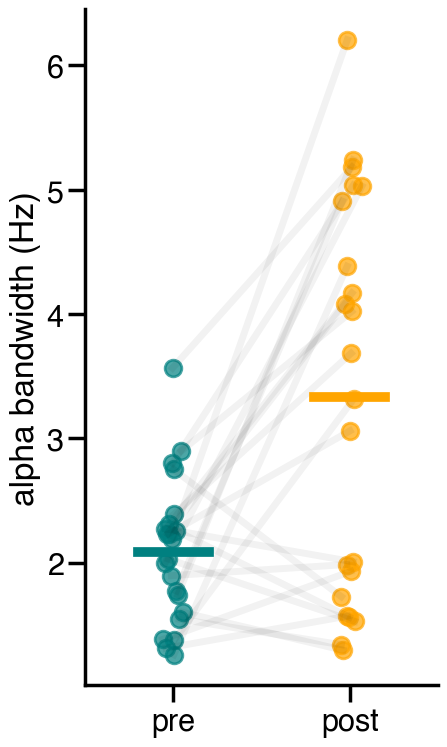

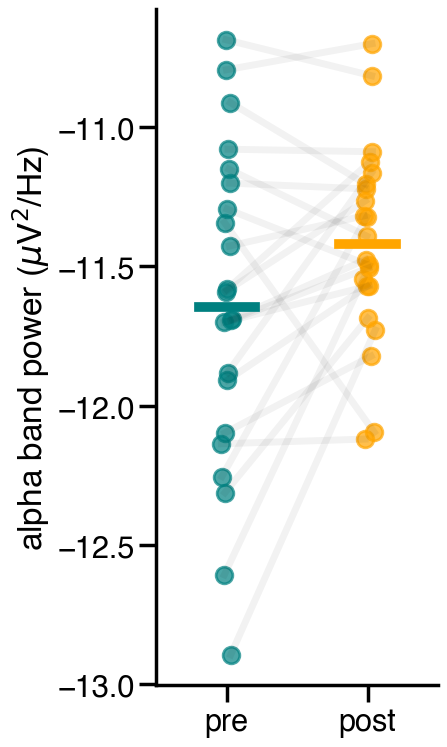

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bw', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)',
          'alpha bandwidth (Hz)', 'alpha band power ($\mu$V$^2$/Hz)' ]



for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

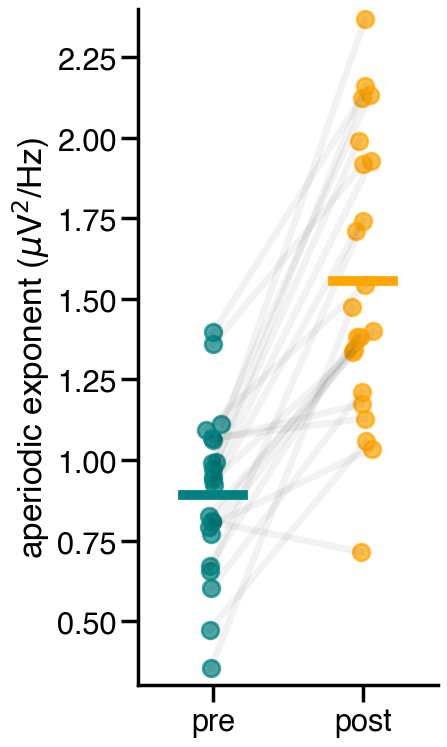

In [15]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 2.4)
sns.despine()
plt.tight_layout()
plt.show()

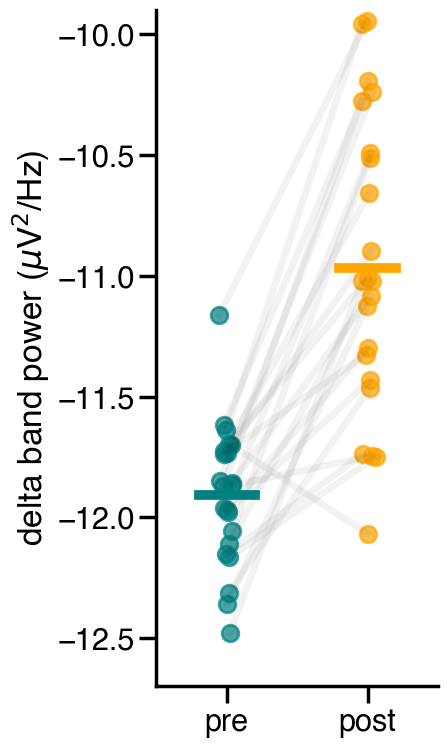

In [16]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -9.9)
sns.despine()
plt.tight_layout()
plt.show()

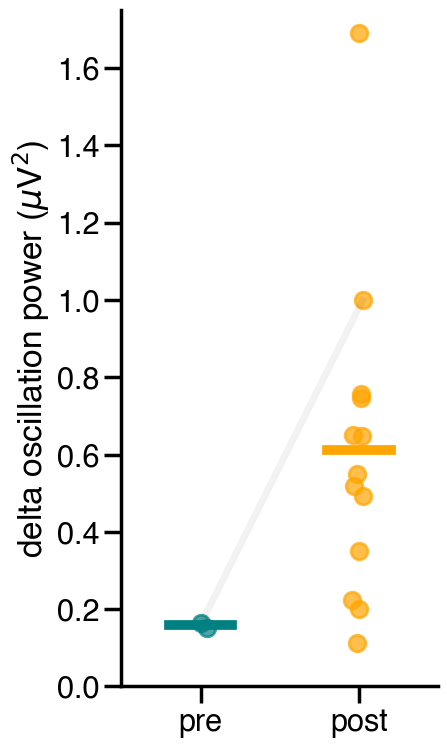

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

## Power Spectra

In [18]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


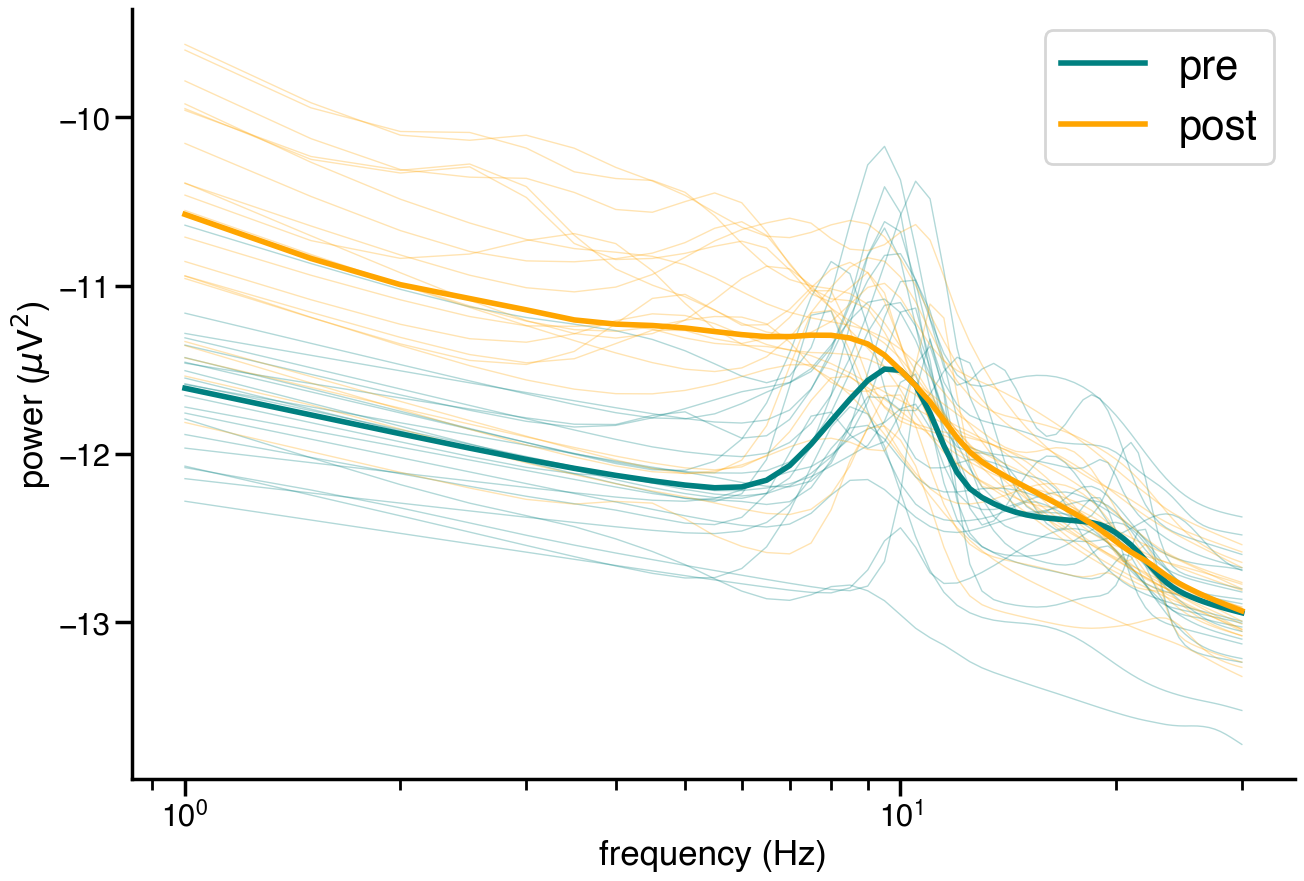

<Figure size 640x480 with 0 Axes>

In [19]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:61], fits_pre_mean[patient], color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:61], fits_post_mean[patient], color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:61], fits_pre_grand_mean, color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:61], fits_post_grand_mean, color='orange', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})

sns.despine()
plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot SpecParam Fits

In [20]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


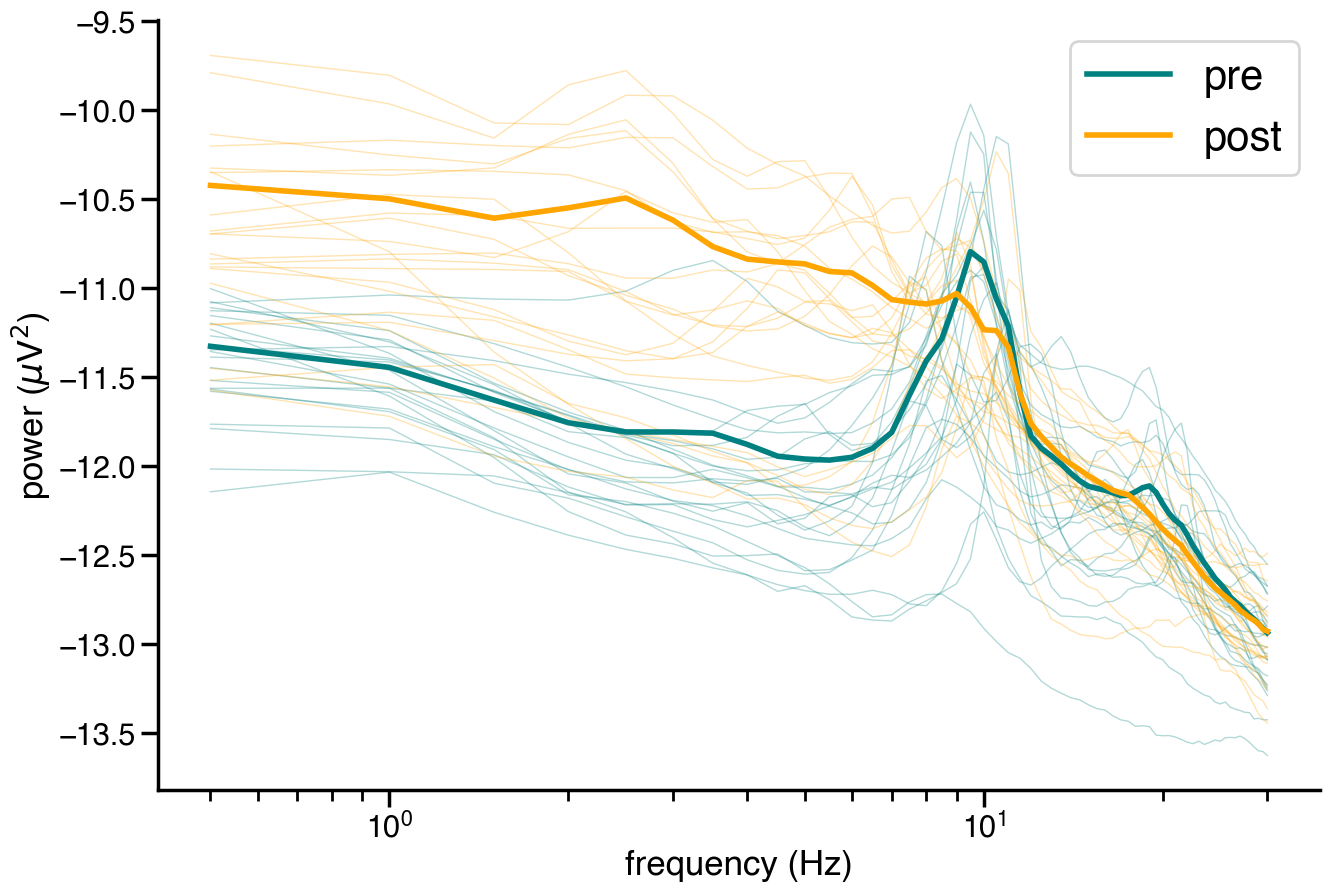

In [21]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[1:61], np.log10(psd_pre_mean[patient,1:61]), color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[1:61], np.log10(psd_post_mean[patient,1:61]), color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[1:61], np.log10(psd_pre_grand_mean[1:61]), color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[1:61], np.log10(psd_post_grand_mean[1:61]), color='orange', linewidth = 4, label='post')

plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [22]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.977611  0.874886    True
          W      pval  normal
0  0.964253  0.579669    True


In [23]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.89 std: 0.25
post: 1.56 std: 0.43


**Distribution of means pre vs. post**

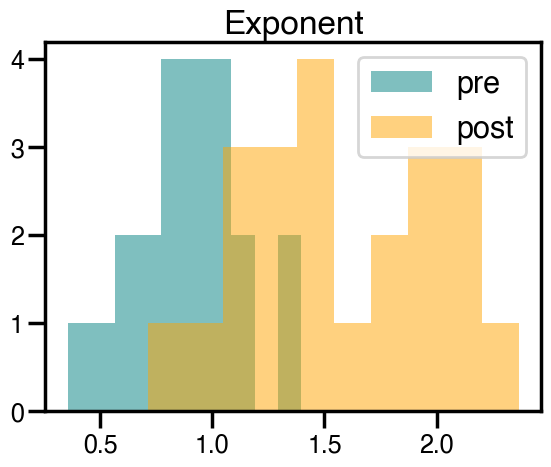

In [24]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [25]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon    2.0   two-sided  0.000001 -0.98419  0.084711


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.09390000000000001 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.117439   21   two-sided  6.514299e-08  [-0.84, -0.49]  1.853308   

             BF10  power  
T-test  2.229e+05    1.0  


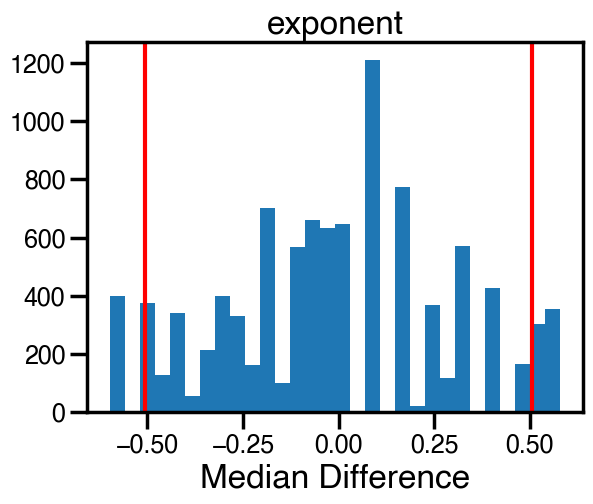

In [26]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

**Normality**

In [27]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.936772  0.169714    True
          W      pval  normal
0  0.962813  0.548143    True


**Distribution of means pre vs. post**

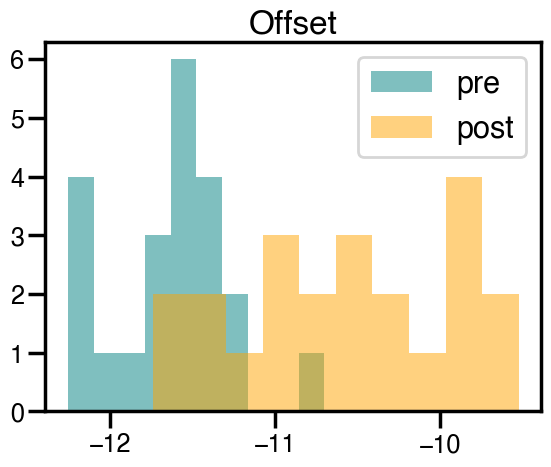

In [28]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

**Wilcoxon Test**

In [29]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon    2.0   two-sided  0.000001 -0.98419  0.097107


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.001 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.771868   21   two-sided  1.823892e-08  [-1.28, -0.79]  1.906974   

            BF10  power  
T-test  7.27e+05    1.0  


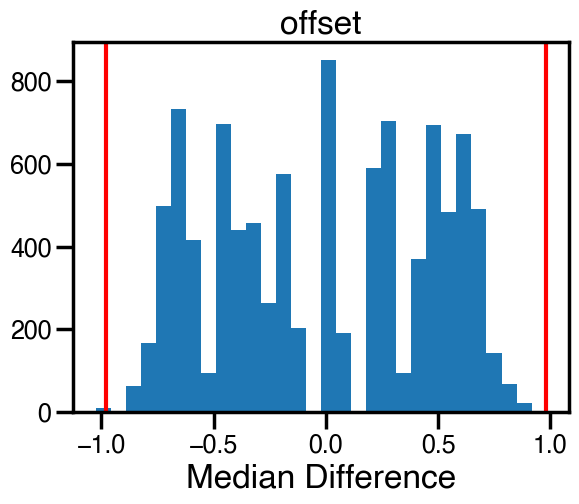

In [30]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [31]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# # normality test
# print(normality(means_pre, method='shapiro'))
# print(normality(means_post, method='shapiro'))

In [32]:
means_pre

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.16495411,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.15115756,        nan,        nan,        nan,        nan,
              nan,        nan])

In [33]:
means_post

array([0.2229723 , 0.11323106, 0.35137184,        nan,        nan,
              nan, 1.68955539, 0.20154726, 0.99917389, 0.75780187,
       0.49291527, 0.54979404,        nan, 0.51735546,        nan,
              nan,        nan,        nan,        nan, 0.64930173,
       0.64742944, 0.74717228])

In [34]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: nan std: nan
post: nan std: nan


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

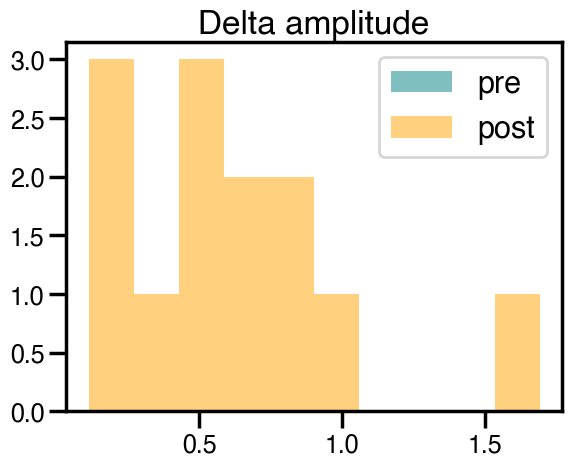

In [35]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

**Wilcoxon**

In [36]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided    1.0 -1.0   0.0


**Permutation Test & T-Test**

The probability from the sampling statistics is =  1.0 



/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/pingouin/parametric.py:226: RuntimeWarning: Degrees of freedom <= 0 for slice
  se = np.sqrt(x.var(ddof=1) / nx)


AssertionError: x must have more than one element.

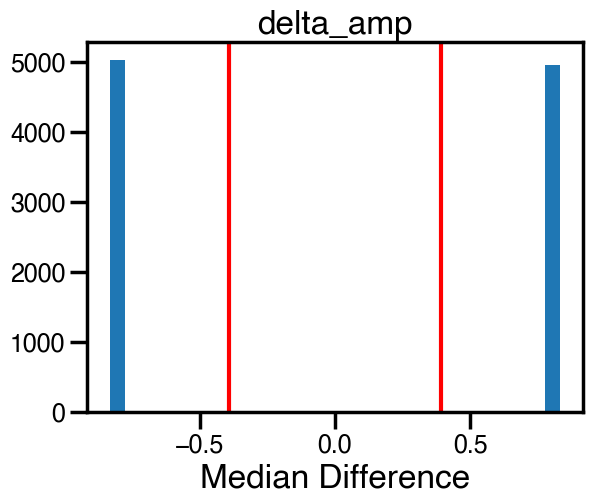

In [37]:
perm_test(exp_df_mean, feature='delta_amp')

### Delta Bandpower: Pre/Post

**Normality**

In [38]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964322  0.581204    True
          W      pval  normal
0  0.961445  0.519033    True


In [39]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.91 std: 0.29
post: -10.97 std: 0.6


#### Distribution of means pre vs. post

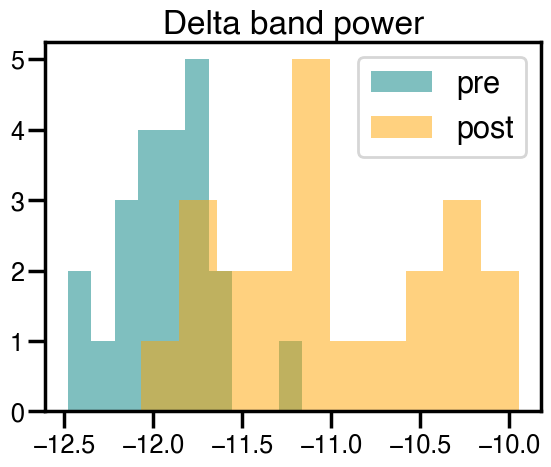

In [40]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [41]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon    2.0   two-sided  0.000001 -0.98419  0.090909


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0011 

               T  dof alternative         p-val          CI95%   cohen-d  \
T-test -8.034683   21   two-sided  7.682943e-08  [-1.19, -0.7]  1.956064   

             BF10  power  
T-test  1.913e+05    1.0  


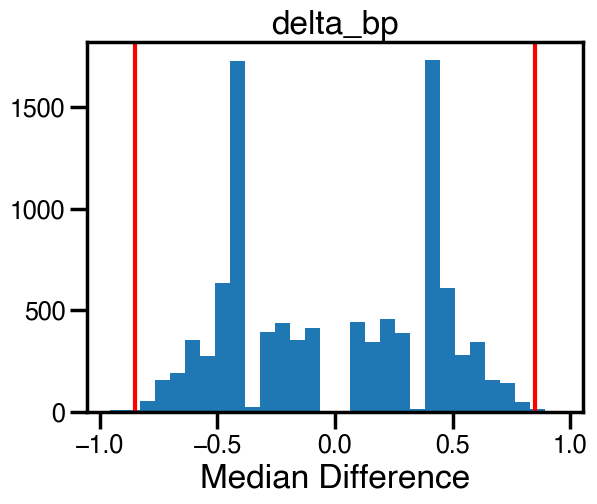

In [42]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [43]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

ValueError: Data must be at least length 3.

#### Distribution of means pre vs. post

In [ ]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [44]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided    1.0 -1.0   0.0


**Permutation Test & T-Test**

The probability from the sampling statistics is =  1.0 



/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/pingouin/parametric.py:226: RuntimeWarning: Degrees of freedom <= 0 for slice
  se = np.sqrt(x.var(ddof=1) / nx)


AssertionError: x must have more than one element.

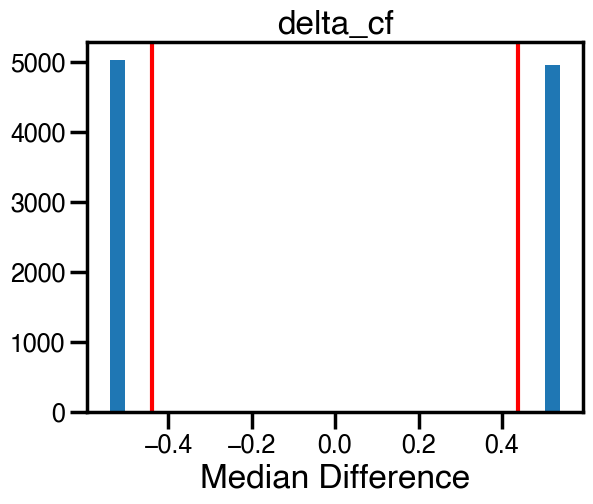

In [45]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [107]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.925977  0.339413    True
          W      pval  normal
0  0.971389  0.823362    True


In [108]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.34 std: 0.14
post: 0.75 std: 0.28


#### Distribution of means pre vs. post

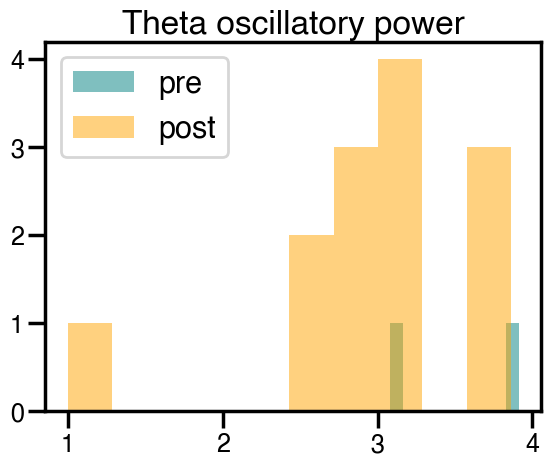

In [46]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [47]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided    1.0 -1.0   0.0


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -6.034583    9   two-sided  0.000194  [-0.62, -0.28]  2.033804   

           BF10     power  
T-test  162.342  0.999889  


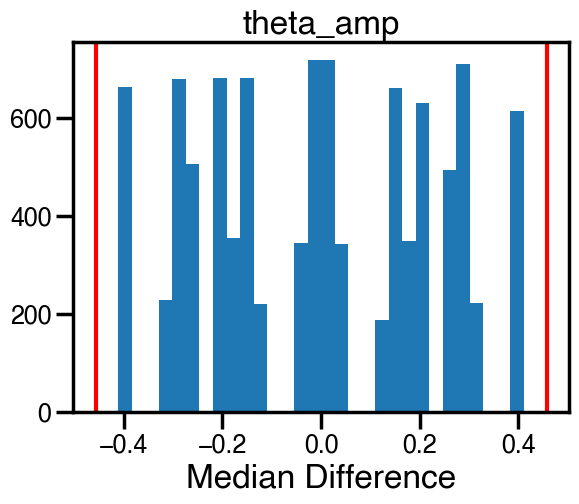

In [48]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Bandpower: Pre/Post

**Normality**

In [49]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.975107  0.825071    True
          W      pval  normal
0  0.918586  0.071067    True


In [50]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.18 std: 0.38
post: -11.19 std: 0.6


#### Distribution of means pre vs. post

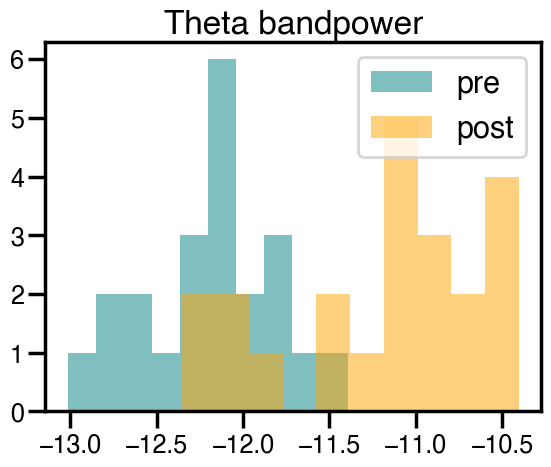

In [51]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta bandpower')
plt.show()

**Wilcoxon Test**

In [52]:
print(wilcoxon(means_pre, means_post))

          W-val alternative         p-val       RBC      CLES
Wilcoxon    1.0   two-sided  9.536743e-07 -0.992095  0.109504


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.479895   21   two-sided  3.196318e-08  [-1.24, -0.75]  1.944593   

             BF10  power  
T-test  4.316e+05    1.0  


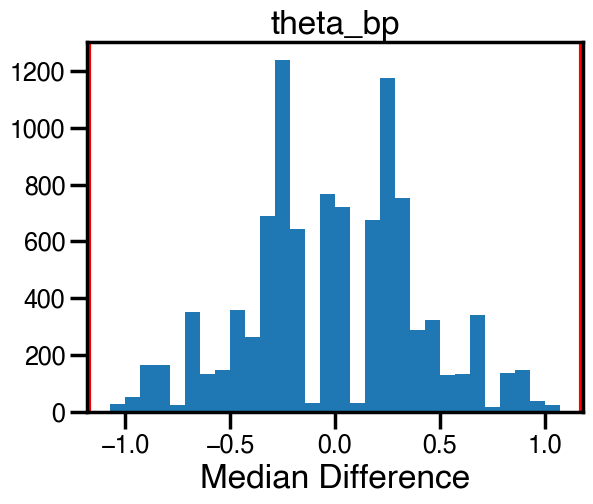

In [53]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [54]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.883711  0.097802    True
         W      pval  normal
0  0.91214  0.093849    True


#### Distribution of means pre vs. post

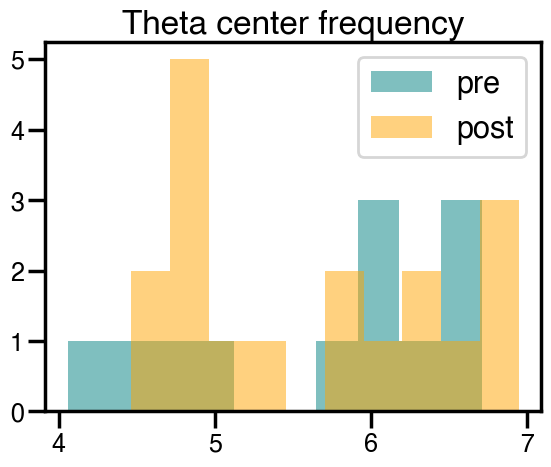

In [55]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [56]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC  CLES
Wilcoxon   10.0   two-sided  0.083984  0.636364  0.69


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.1961 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  1.428557    9   two-sided  0.186903  [-0.32, 1.4]  0.711498  0.682   

           power  
T-test  0.519247  


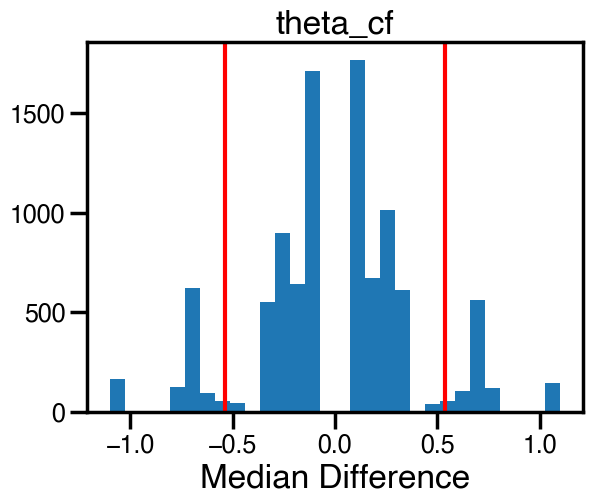

In [57]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [58]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.952301  0.350563    True
          W      pval  normal
0  0.921326  0.080984    True


In [59]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.23 std: 0.5
post: 0.84 std: 0.31


#### Distribution of means pre vs. post

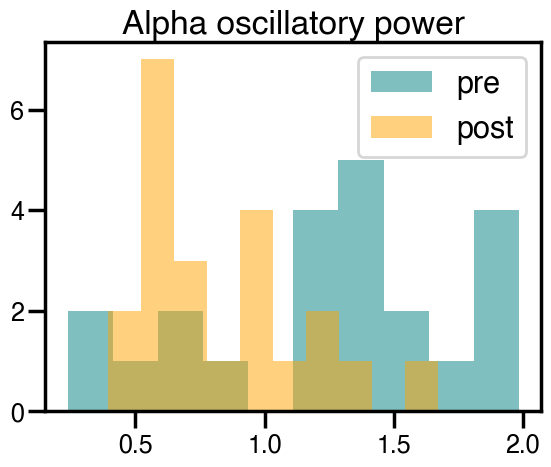

In [60]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [61]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   34.0   two-sided  0.001673  0.731225  0.747934


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  3.672022   21   two-sided  0.001419  [0.17, 0.61]  0.922197  26.384   

           power  
T-test  0.984629  


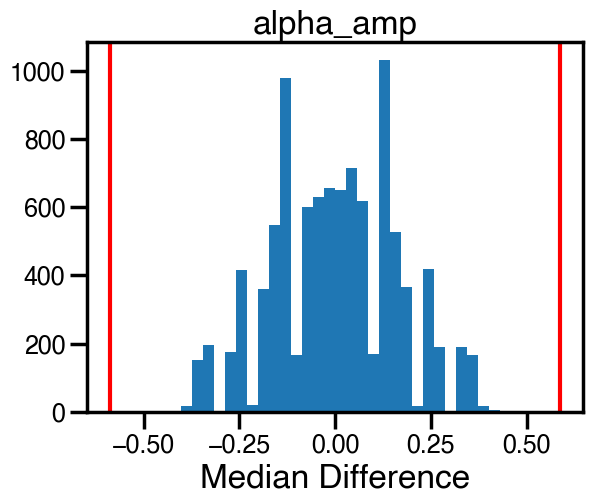

In [62]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Bandpower: Pre/Post

**Normality**

In [63]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.982111  0.945734    True
          W      pval  normal
0  0.976989  0.863069    True


In [64]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.65 std: 0.57
post: -11.42 std: 0.35


#### Distribution of means pre vs. post

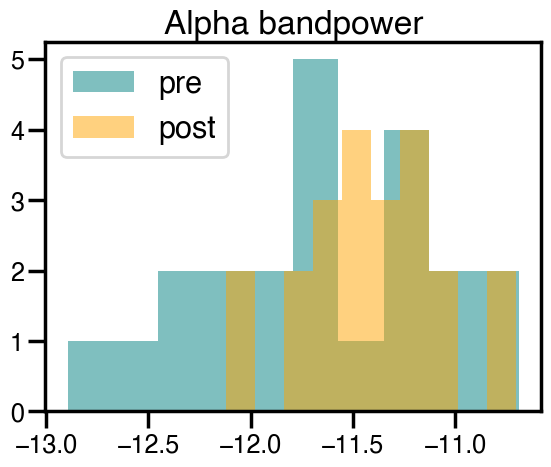

In [65]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha bandpower')
plt.show()

**Wilcoxon Test**

In [66]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   62.0   two-sided  0.035875 -0.509881  0.376033


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0133 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.301038   21   two-sided  0.031733  [-0.43, -0.02]  0.473082  1.927   

           power  
T-test  0.562365  


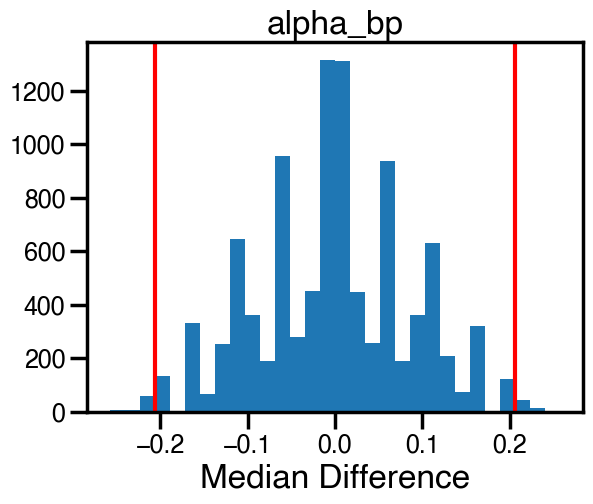

In [67]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [68]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.967978  0.664282    True
          W      pval  normal
0  0.951651  0.340436    True




#### Distribution of means pre vs. post

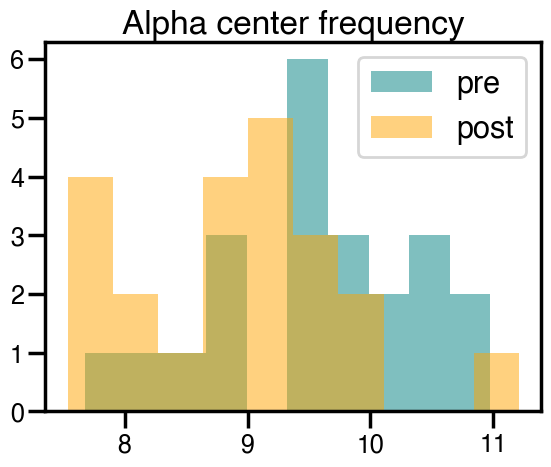

In [69]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [70]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   27.0   two-sided  0.000593  0.786561  0.710744


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0009 

               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  4.057185   21   two-sided  0.000567  [0.31, 0.97]  0.742376  58.885   

           power  
T-test  0.912917  


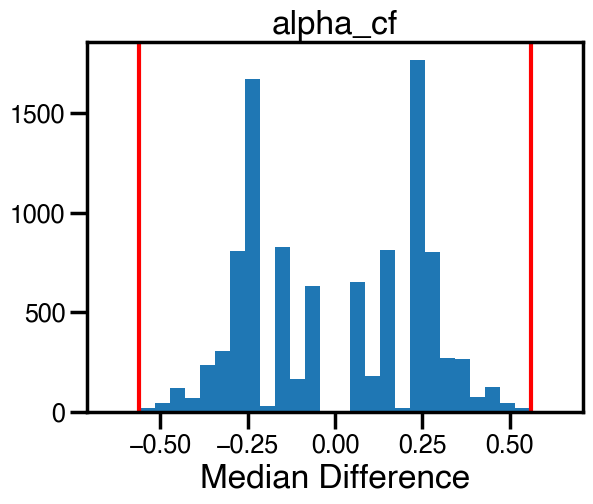

In [71]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta/theta/alpha oscillation per participant, per pre/post

### Delta Percentage

In [72]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [73]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [74]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc


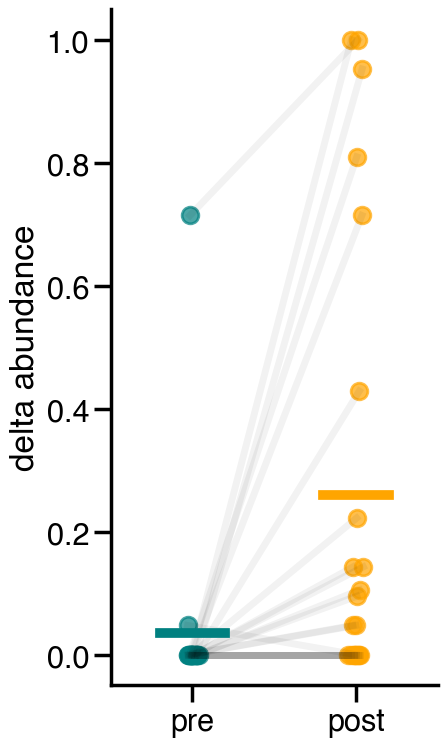

In [75]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylabel('delta abundance')
plt.tight_layout()
sns.despine()
plt.show()

**Normality**

In [76]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

         W          pval  normal
0  0.24279  1.050084e-09   False
          W      pval  normal
0  0.706382  0.000024   False


In [77]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.03 std: 0.15
post: 0.26 std: 0.36


**Wilcoxon Test**

In [78]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    2.0   two-sided  0.001674 -0.961905  0.242769


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0010999999999999998 

               T  dof alternative    p-val           CI95%   cohen-d   BF10  \
T-test -3.157394   21   two-sided  0.00475  [-0.37, -0.08]  0.793051  9.328   

           power  
T-test  0.943504  


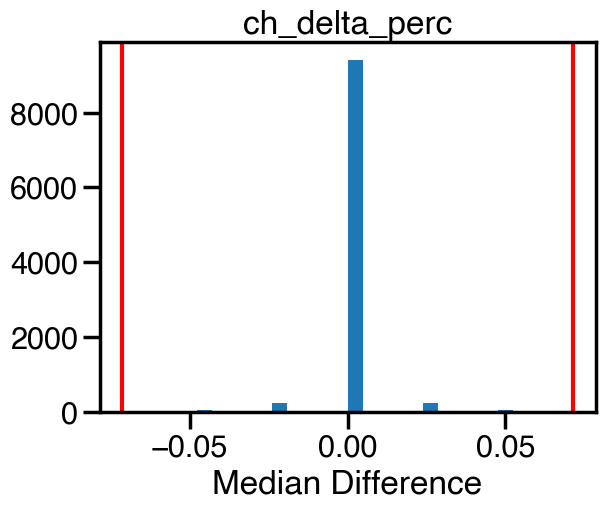

In [79]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [80]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [81]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [82]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

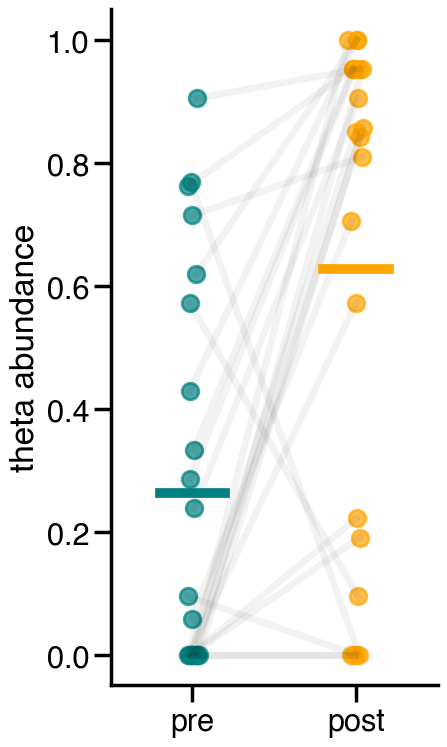

In [83]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.tight_layout()
plt.show()

In [84]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [85]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.26 std: 0.31
post: 0.63 std: 0.39


**Wilcoxon Test**

In [86]:
print(wilcoxon(perc_theta_pre, perc_theta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   25.5   two-sided  0.003177 -0.757143  0.232438


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

              T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.66121   21   two-sided  0.001456  [-0.57, -0.16]  1.002964  25.803   

           power  
T-test  0.994134  


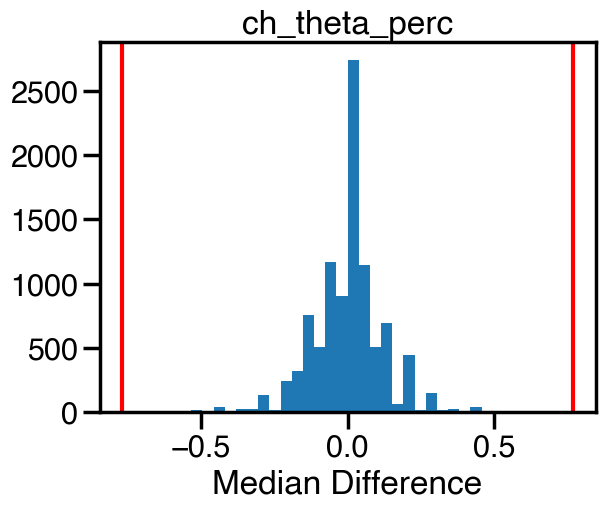

In [87]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [88]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [89]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [90]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

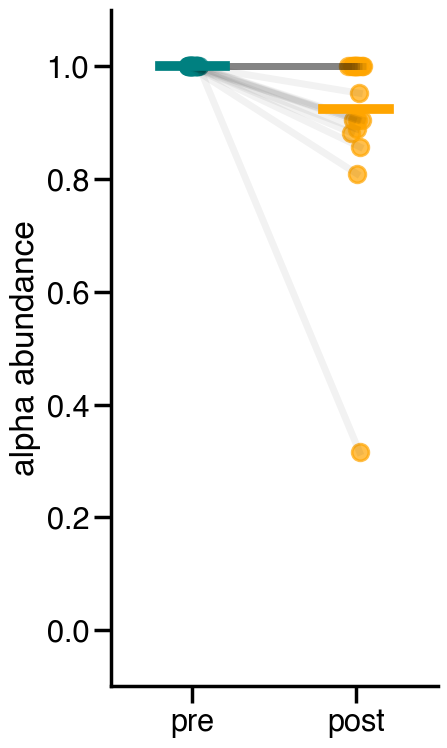

In [91]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
plt.ylim([-0.1,1.1])
sns.despine()
plt.tight_layout()
plt.show()

In [92]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [93]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 1.0 std: 0.0
post: 0.92 std: 0.14


**Wilcoxon Test**

In [94]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))

          W-val alternative     p-val  RBC      CLES
Wilcoxon    0.0   two-sided  0.005603  1.0  0.727273


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val         CI95%  cohen-d  BF10  \
T-test  2.407306   21   two-sided  0.025351  [0.01, 0.14]  0.72583  2.31   

           power  
T-test  0.900629  


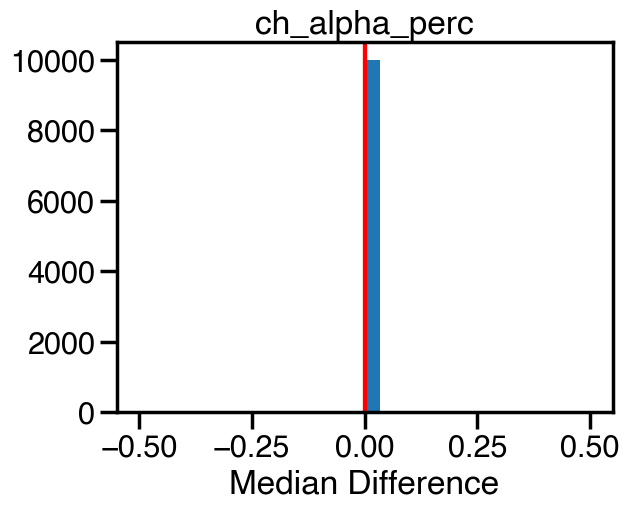

In [95]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [96]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [97]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [98]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,3,post,1.473675,-10.578143,0.222972,-11.021692,0.681705,-11.112882,6.288253,3.140894,0.477906,-11.571773,1.986440,9.941734,21,1.000000,2,0.095238,19,0.904762
1,3,pre,0.355315,-12.011401,NaN,-12.110336,0.254162,-12.194086,6.657136,NaN,0.660940,-11.909060,1.897472,9.629369,13,0.619048,0,0.000000,21,1.000000
2,4,post,1.034357,-11.742207,0.113231,-12.066982,0.276528,-12.357611,4.462445,2.901583,0.999677,-12.095250,1.563205,9.096866,12,0.571429,1,0.047619,21,1.000000
3,4,pre,0.792634,-11.537213,NaN,-11.701027,NaN,-12.193141,NaN,NaN,1.391490,-11.343510,2.258704,10.185415,0,0.000000,0,0.000000,21,1.000000
4,10,post,1.334032,-10.979192,0.351372,-11.297969,1.061185,-10.992127,4.829297,3.849226,1.336716,-11.164395,3.316719,8.472483,20,0.952381,1,0.047619,21,1.000000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the bandpower differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [99]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1750/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,-1.118360,-1.433258,NaN,-1.088644,-0.427543,-1.081204,0.368883,NaN,0.183033,-0.337287,-0.312365,-0.380952,-0.095238,0.095238,3
3,-0.241722,0.204995,NaN,0.365954,NaN,0.164470,NaN,NaN,0.391813,0.751739,1.088549,-0.571429,-0.047619,0.000000,4
5,-0.396284,-0.695895,NaN,-0.671267,-0.759861,-1.141599,1.277956,NaN,-0.182383,-0.716839,1.945478,-0.190476,-0.047619,0.000000,10
7,-0.111824,-0.177952,NaN,-0.121960,NaN,-0.191882,NaN,NaN,0.033367,-0.130260,-0.078159,0.000000,0.000000,0.000000,13
9,-0.571126,-0.812287,NaN,-0.776271,-0.520536,-1.146459,1.016063,NaN,0.159167,-0.213639,1.423675,-0.666667,0.000000,0.000000,16
11,-0.572083,-0.725644,NaN,-0.542989,NaN,-0.864079,NaN,NaN,-0.361567,-0.626162,0.798814,-0.190476,0.000000,0.142857,18
13,0.093527,-0.567191,NaN,-0.847825,NaN,-0.778840,NaN,NaN,1.059391,-0.016943,1.321629,-0.222222,-0.222222,0.111111,19
15,-0.610763,-1.350830,NaN,-1.232367,NaN,-1.554085,NaN,NaN,0.072762,-1.062499,2.161989,-0.842105,-0.105263,0.684211,25
17,-0.560520,-1.346332,-0.83422,-1.542339,-0.394533,-1.710405,-2.384909,-0.540021,-0.383119,-1.164586,1.276967,0.476190,-0.285714,0.095238,29
19,-0.728003,-1.153618,NaN,-1.216201,-0.379174,-0.988577,0.194567,NaN,0.928471,0.129019,0.497789,-0.095238,-0.714286,0.000000,31


In [100]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     13.41
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           0.000233
Time:                        14:30:59   Log-Likelihood:                -7.8913
No. Observations:                  22   AIC:                             21.78
Df Residuals:                      19   BIC:                             25.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2813      0.162     -1.734

In [101]:
model = ols('theta_bp ~ exponent + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     5.906
Date:                Wed, 08 Feb 2023   Prob (F-statistic):             0.0101
Time:                        14:30:59   Log-Likelihood:                -12.240
No. Observations:                  22   AIC:                             30.48
Df Residuals:                      19   BIC:                             33.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4131      0.202     -2.043

In [102]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     5.996
Date:                Wed, 08 Feb 2023   Prob (F-statistic):            0.00511
Time:                        14:30:59   Log-Likelihood:                -6.1642
No. Observations:                  22   AIC:                             20.33
Df Residuals:                      18   BIC:                             24.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2286      0.158     -1.449

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='theta_amp', ylabel='theta_bp'>

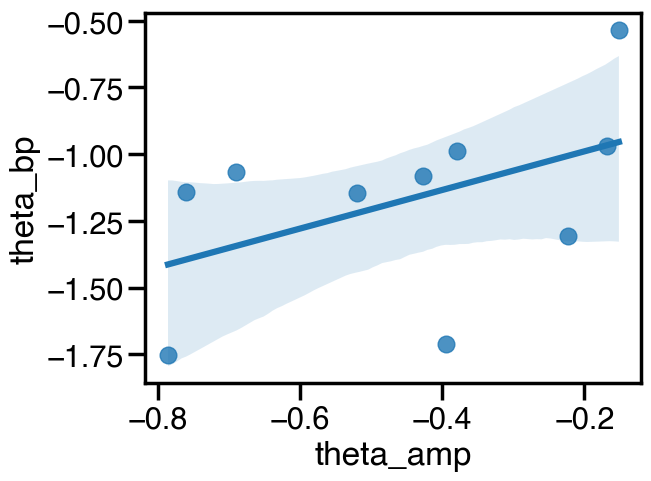

In [103]:
sns.regplot(diff_df_mean_wperc['theta_amp'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_theta_perc', ylabel='theta_bp'>

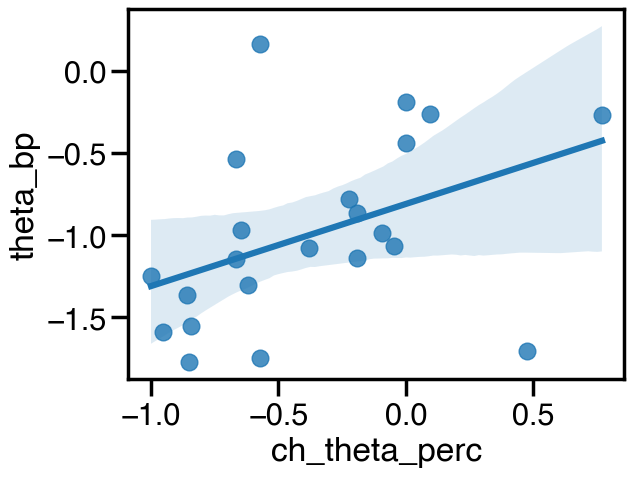

In [104]:
sns.regplot(diff_df_mean_wperc['ch_theta_perc'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='offset', ylabel='theta_bp'>

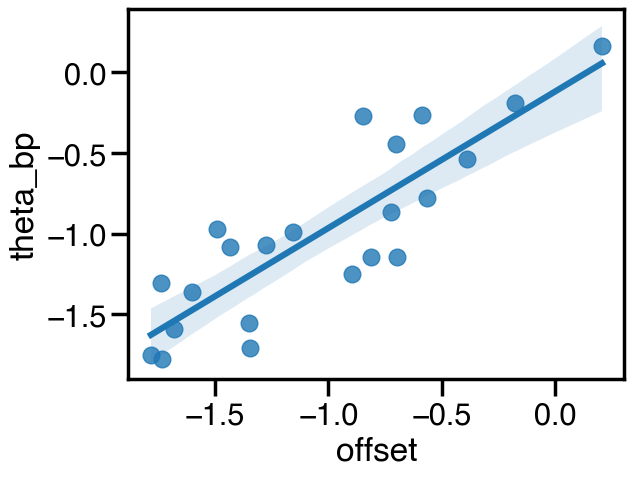

In [105]:
sns.regplot(diff_df_mean_wperc['offset'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='theta_bp'>

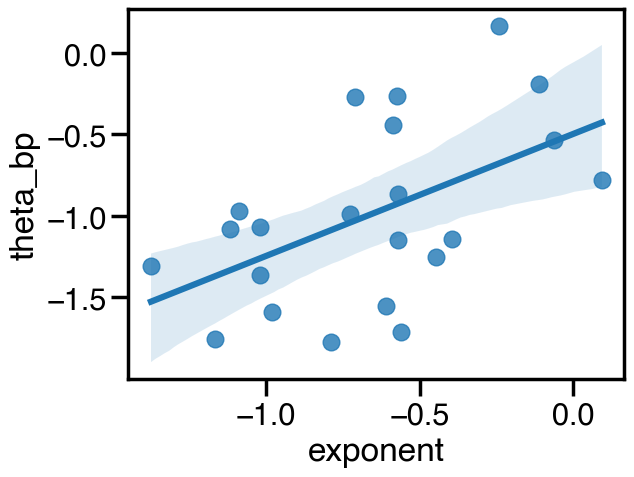

In [106]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['theta_bp'])